In [1]:
import numpy as np

import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision.datasets import MNIST
from IPython.display import display
from configargparse import ArgumentParser
import yaml
import os
import logging
import pytorch_lightning as pl
from pytorch_lightning import loggers, Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import importlib

from DataManager import DataManager
import gvdl
importlib.reload(gvdl)
from gvdl.models.conv_mmd_vae import ConvolutionalMMD_VAE

from gvdl.utils.helpers import _log_level_string_to_int, _LOG_LEVEL_STRINGS
from gvdl.utils.functions import calc_output_size_convnet, calc_output_size_transpose_convnet

from dotenv import load_dotenv
load_dotenv()

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_ds = MNIST("/home/gvisona/datasets", train=True, download=True, transform=torchvision.transforms.ToTensor())
val_ds = MNIST("/home/gvisona/datasets", train=False, download=True, transform=torchvision.transforms.ToTensor())

In [3]:
# Custom image dataset
sample = train_ds[0][0].squeeze()


calc_output_size_convnet(hparams.input_size, hparams.conv_encoder_kernel_sizes, hparams.conv_encoder_paddings,
                                               hparams.conv_encoder_strides, hparams.conv_encoder_dilations)

calc_output_size_transpose_convnet(4, hparams.conv_decoder_kernel_sizes, 
                                   paddings=hparams.conv_decoder_paddings, 
                                   strides=hparams.conv_decoder_strides, 
                                   dilations=hparams.conv_decoder_dilations, 
                                   output_paddings=None)

In [4]:
class Args:
    seed=0
    experiment_name="MMD_VAE_MNIST"
    model_dir="/home/gvisona/datasets"
    log_dir="/home/gvisona/datasets"
    log_level=20
    neptune_project="gvisona/idr0017"
    gpus=0
    max_epochs=10
    f="/home/gvisona/.local/share/jupyter/runtime/kernel-13ddf605-9d2e-4ce0-bbf2-45ed98c3efea.json"
    reconstruction_loss="MSE"
    beta=0.00001
    warmup_epochs=0
    input_size=28
    input_channels=1
    crop_output=True
    latent_dim=2
    conv_batch_norm=False
    fc_batch_norm=False
    fc_dropout_p=0.1
    conv_encoder_feature_maps=[8, 16, 32]
    conv_encoder_kernel_sizes=[4, 4, 4]
    conv_encoder_paddings=[1, 1, 1]
    conv_encoder_strides=[2, 2, 2]
    conv_encoder_dilations=[1, 1, 1]
    conv_encoder_activations="ReLU"
    fc_encoder_hidden_layers=[64]
    fc_encoder_activations="ReLU"
    conv_decoder_feature_maps=[64, 32, 8]
    conv_decoder_kernel_sizes=[5, 4, 4]
    conv_decoder_paddings=[2, 1, 1]
    conv_decoder_strides=[2, 2, 2]
    conv_decoder_dilations=[1, 1, 1]
    conv_decoder_activations="ReLU"
    conv_decoder_final_activation=False
    fc_decoder_hidden_layers=[64, 64*4*4]
    fc_decoder_activations="ReLU"
    output_activation=False
    batch_size=64
    num_workers=6
    learning_rate=0.01
    weight_decay=0.00002
    lr_scheduler=None
    scheduler_gamma=None
    scheduler_step_size=None
    
    
hparams=Args()
# set seeds
torch.manual_seed(hparams.seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(hparams.seed)

In [5]:
tb_logger = loggers.TensorBoardLogger(hparams.log_dir)
neptune_logger = loggers.NeptuneLogger(
    project_name=hparams.neptune_project,
    params=vars(hparams),
    experiment_name=hparams.experiment_name)
logging.basicConfig(level=hparams.log_level)
with open(os.path.join(hparams.log_dir, 'config.yml'), 'w') as outfile:
    yaml.dump(hparams.__dict__, outfile, default_flow_style=False)
    
model = ConvolutionalMMD_VAE(hparams, train_ds, val_ds)

early_stopping_cb = EarlyStopping('val_loss', patience=5)
trainer = Trainer(gpus=hparams.gpus,
                  max_epochs=hparams.max_epochs,
                  default_save_path=hparams.model_dir,
                  logger=[tb_logger, neptune_logger],
                  callbacks=[early_stopping_cb])
  

INFO:lightning:NeptuneLogger was initialized in online mode
INFO:lightning:GPU available: False, used: False


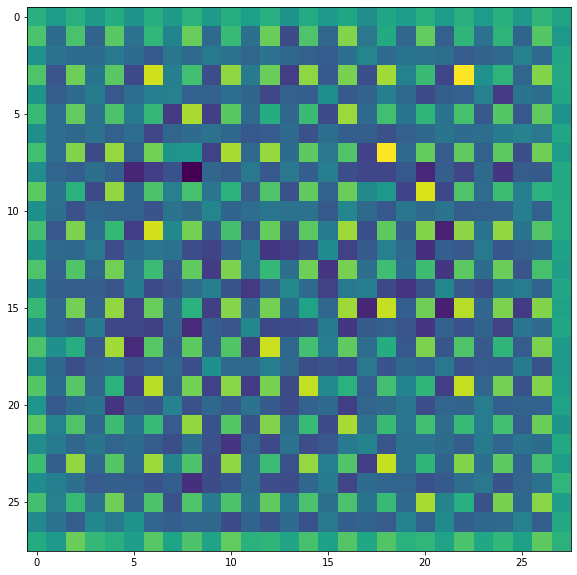

In [6]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(model.forward(sample[None, None, :,:])[0].squeeze().detach().numpy())
plt.show()

In [7]:
trainer.fit(model)

https://ui.neptune.ai/gvisona/idr0017/e/IDR-26


INFO:lightning:
   | Name                                                                         | Type                          | Params
---------------------------------------------------------------------------------------------------------------------------
0  | conv_encoder                                                                 | ConvolutionalEncoder          | 28 K  
1  | conv_encoder.encoder_conv                                                    | ConvolutionalModule           | 10 K  
2  | conv_encoder.encoder_conv.convolutional_module                               | Sequential                    | 10 K  
3  | conv_encoder.encoder_conv.convolutional_module.Block_1                       | Sequential                    | 136   
4  | conv_encoder.encoder_conv.convolutional_module.Block_1.Conv                  | Conv2d                        | 136   
5  | conv_encoder.encoder_conv.convolutional_module.Block_1.Act                   | ReLU                          | 0     

1